In [1]:
from functools import partial

import numpy as onp

import jax.numpy as jnp
import jax

import optax

import matplotlib.pyplot as plt

from chemtrain import quantity, trainers, ensemble

# Differentiable Trajectory Reweighting (DiffTRe)

## Concepts

Molecular dynamics is an efficient method to sample positions $\mathbf r$ from a 
molecular systems.
However, back-propagating gradients through the simulation is costly and
prone to exploding gradients [^Ingraham2019].
Instead, DiffTRe [^Thaler2021] estimates gradients of ensemble averages by
employing a probabilistic perspective like in the Umbrella Sampling
method [^Torrie1977].

In the umbrella sampling method, biasing a potential enables an
efficient computation of ensemble averages of an unbiased potential. 
A postprocessing step then corrects the effect of the bias on the ensemble
average.
This correction re-weights the collected samples by accounting for the change
in relative probability between the biased reference and unbiased target
distribution.

For a trainable target potential $U_\theta$ and samples $x^{(i)}$ from the
biased reference potential $\tilde U$, the discretized reweighting reads

```{math}
\langle a \rangle_{U_\theta} \approx \sum_{i=1}^N w^{(i)}a\left(x^{(i)}\right), \quad w^{(i)} = \frac{e^{-\beta\left(U_\theta(x^{(i)}) - \tilde U(x^{(i)})\right)}}{\sum_{j=1}^Ne^{-\beta\left(U_\theta(x^{(j)}) - \tilde U(x^{(j)})\right)}}
```

Since the reference and target potential are independent, DiffTRe
assumes that the reference potential $\tilde U$ no longer depend on the
learnable parameters.
Therefore, also the samples $x^{(i)}$ are independent of the target potential.
Hence, the only contribution to the gradients arises through the weights 
$w^{(i)}$ and the instantaneous states $a(x)$ of the observables.
Thus, by employing this umbrella sampling procedure, DiffTRe can compute
gradients of the loss function without differentiating through the costly
molecular dynamics simulation.

Unfortunately, the statistical error of the approximation grows exponentially
fast with the difference between the target and the reference
potential [^Ceriotti2021].
If the number of effective samples[^Carmichael2012]

```{math}
N_{eff} = e^{-\sum_{i=1}^N w^{(i)}\log w^{(i)}}
```

decreases below a threshold, DiffTRe replaces the reference potential by the
current potential $\tilde U \leftarrow U_\theta$ and resamples the conformations
$x^{(i)}$.

To accelerate the resampling and use the full computational capabilities of a
GPU, DiffTRe enables to sample from multiple simulations in parallel, using
the vectorization capabilities of JAX.
Additionally, DiffTRe provides the option to re-seed these parallel simulations
by choosing initial states from the simulated trajectory, with probability
corresponding to their weight.
In principle, this resampling of initial states enables a faster convergence
of the simulated trajectories to the new equilibrium distribution.

## Toy Example

For a canonical system of two-particles connected by a spring,
the Boltzmann factor is

```{math}
  \rho(\mathbf{r}) \propto e^{-\frac{1}{2}b(||\mathbf{r}_1 - \mathbf{r}_2|| - r_0)^2}, \quad b = \beta\cdot b_S,
```
with temperature dependent effective spring constant $b$.

Hence, the probability of finding the two identical
particles in a distance of $r$ is
```{math}
  p(r) = \sqrt{\frac{2b}{\pi}}\left(\frac{b}{1 + br_0^2}\right)r^{2}e^{-\frac{1}{2}b(r - r_0)^2}.
```
The term $r^2$ in front of the exponential factor emerges in the transformation
from cartesian to spherical coordinates.
With this probability distribution, we can directly compute the radial
distribution function.

```{math}
  g(r) = \frac{V}{4 \pi r^2 N^2}p(r).
```

In [2]:
box = 1.0

def radial_distribution(r, r_0=0.35, b=250.0, kbt=2.56):
    b = b / kbt
    norm = onp.sqrt(onp.pi / (2 * b)) * (1 + b * r_0 ** 2) / b
    g_r = box ** 3 / (16 * onp.pi) * onp.exp(-0.5 * b * (r - r_0) ** 2) / norm
    return g_r

We now want to learn the parameters of this harmonic bond based on a reference
radial distribution function.

In [3]:
r = onp.linspace(0.0, box, 100)
target = onp.vstack((r, radial_distribution(r))).T

Although we could find an analytic relation to the potential parameters,
this is not possible for more complex systems.
Thus, we need to simulate this relation and set up a model of the system.

Thus, we first need to define an appropriate potential model.

In [4]:
from jax_md import energy, space, simulate, partition

def energy_fn_template(params):
    energy_fn = energy.simple_spring_bond(
        displacement_fn,
        jnp.asarray([[0, 1]]),
        length=params["r_0"],
        epsilon=100 * params["scaled_b"],
        alpha=2.0
    )
    return energy_fn

init_params = {"r_0": 0.3, "scaled_b": 1.5}


Secondly, we need a routine to simulate the positions of the particles.

In [5]:
r_init = jnp.asarray([[0.0, 0.0, 0.0], [0.11, 0.09, 0.12]])
displacement_fn, shift_fn = space.periodic_general(box)

dt = 0.01
timings = ensemble.sampling.process_printouts(dt, 1100, 100, 1.0)

simulator_template = partial(
    simulate.nvt_langevin, shift_fn=shift_fn,
    dt=dt, kT=2.56, gamma=0.5, mass=10.0)

neighbor_fn = partition.neighbor_list(displacement_fn, box, 0.5)

simulator_init, _ = simulator_template(energy_fn_template(init_params))
simulator_init_state = simulator_init(jax.random.PRNGKey(0), r_init)
nbrs_init = neighbor_fn.allocate(r_init)

reference_state = ensemble.sampling.SimulatorState(
    sim_state=simulator_init_state, nbrs=nbrs_init)

system = {
    'displacement_fn': displacement_fn,
    'reference_box': box
}

/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


There are multiple classical approaches that enable the inversion of a 
radial distribution function into a pair-potential.
However, they are not applicable to general models, e.g., neural networks.
Thus, DiffTRe enables gradient based training, which we are going to set up in
the next step.

In [6]:
import optax

lr_schedule = optax.exponential_decay(-0.05, 300, 0.1)
optimizer = optax.chain(
    optax.scale_by_rms(0.9),
    optax.scale_by_schedule(lr_schedule)
)

Finally, we have to specify the training targets, which is in our case the
radial distribution function.
Since we only have two particles in a box, we approximate the distribution 
with slightly coarser bins.

In [7]:
target_builder = quantity.targets.TargetBuilder()

target_builder['rdf'] = quantity.targets.init_radial_distribution_target(
    target, rdf_start=0.00, rdf_cut=1.0, nbins=50)

targets, compute_fns = target_builder.build(system)

We now created a numerical representation of the system and can run the trainer.

In [8]:
trainer = trainers.Difftre(
    init_params, optimizer, reweight_ratio=0.99
)

trainer.add_statepoint(
  energy_fn_template, simulator_template, neighbor_fn, timings, 
  {'kT': 2.56}, compute_fns, reference_state, targets=targets)


/Users/paul/Lokal/chemtrain/chemtrain/ensemble/reweighting.py:777: UserWarning: Propagation function is not safe by default. Do not forget to use the wrapper around the compute function to ensure that the neighborlist does not overflow.
  warnings.warn(


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


Time for trajectory initialization 0: 0.0010082642237345377 mins


In [9]:
trainer.train(300)

/Users/paul/miniconda3/envs/chemtrain/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:221: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,



[DiffTRe] Epoch 0
	Epoch loss = 0.09795
	Gradient norm: 10.506043434143066
	Elapsed time = 0.055 min
[Statepoint 0]
	kT = 2.554 ref_kT = 2.560
	Predicted entropy: -4.3101167079839797e-10
	Predicted free_energy: 0.0



[DiffTRe] Epoch 1
	Epoch loss = 0.07742
	Gradient norm: 0.8525797724723816
	Elapsed time = 0.056 min
[Statepoint 0]
	kT = 2.533 ref_kT = 2.560
	Predicted entropy: 0.0018681904766708612
	Predicted free_energy: -1.0972963571548462

[DiffTRe] Epoch 2
	Epoch loss = 0.03322
	Gradient norm: 0.5101307034492493
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.638 ref_kT = 2.560
	Predicted entropy: 0.001785657717846334
	Predicted free_energy: -0.9932505488395691

[DiffTRe] Epoch 3
	Epoch loss = 0.00760
	Gradient norm: 0.05841796100139618
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.707 ref_kT = 2.560
	Predicted entropy: 0.0013491285499185324
	Predicted free_energy: -0.7505378127098083

[DiffTRe] Epoch 4
	Epoch loss = 0.00474
	Gradient norm: 0.0002536648535169661
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.707 ref_kT = 2.560
	Predicted entropy: 0.0010208024177700281
	Predicted free_energy: -0.5989142656326294

[DiffTRe] Epoch 5
	Epoch loss = 0.00389
	Gradient norm: 0.000107334191852714


[DiffTRe] Epoch 7
	Epoch loss = 0.01066
	Gradient norm: 0.02716369368135929
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.530 ref_kT = 2.560
	Predicted entropy: 0.0006776080699637532
	Predicted free_energy: -0.45870763063430786

[DiffTRe] Epoch 8
	Epoch loss = 0.00860
	Gradient norm: 0.021975144743919373
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.530 ref_kT = 2.560
	Predicted entropy: 0.00028133782325312495
	Predicted free_energy: -0.28832554817199707

[DiffTRe] Epoch 9
	Epoch loss = 0.00751
	Gradient norm: 0.032901957631111145
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.530 ref_kT = 2.560
	Predicted entropy: 0.00037126539973542094
	Predicted free_energy: -0.3406595289707184

[DiffTRe] Epoch 10
	Epoch loss = 0.00202
	Gradient norm: 0.0035837325267493725
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.491 ref_kT = 2.560
	Predicted entropy: -1.853854314504133e-06
	Predicted free_energy: -0.1714494228363037

[DiffTRe] Epoch 11
	Epoch loss = 0.00187
	Gradient norm: 0.004955


[DiffTRe] Epoch 18
	Epoch loss = 0.02263
	Gradient norm: 0.6737930178642273
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.694 ref_kT = 2.560
	Predicted entropy: 0.0009654213790781796
	Predicted free_energy: -0.5509755611419678

[DiffTRe] Epoch 19
	Epoch loss = 0.00442
	Gradient norm: 0.2763514518737793
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.688 ref_kT = 2.560
	Predicted entropy: -0.00046069524250924587
	Predicted free_energy: 0.0004216432571411133

[DiffTRe] Epoch 20
	Epoch loss = 0.01645
	Gradient norm: 0.15120938420295715
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.595 ref_kT = 2.560
	Predicted entropy: 0.0004804194322787225
	Predicted free_energy: -0.41081511974334717

[DiffTRe] Epoch 21
	Epoch loss = 0.00430
	Gradient norm: 0.06390947103500366
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.717 ref_kT = 2.560
	Predicted entropy: -0.00033849265309982
	Predicted free_energy: -0.05162942409515381



[DiffTRe] Epoch 22
	Epoch loss = 0.00805
	Gradient norm: 0.29341158270835876
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.631 ref_kT = 2.560
	Predicted entropy: 9.960201714420691e-05
	Predicted free_energy: -0.24944254755973816

[DiffTRe] Epoch 23
	Epoch loss = 0.00494
	Gradient norm: 0.27286404371261597
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.513 ref_kT = 2.560
	Predicted entropy: -0.001000120653770864
	Predicted free_energy: 0.2693993151187897

[DiffTRe] Epoch 24
	Epoch loss = 0.00604
	Gradient norm: 0.13143251836299896
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.480 ref_kT = 2.560
	Predicted entropy: 0.00013691515778191388
	Predicted free_energy: -0.236601322889328



[DiffTRe] Epoch 25
	Epoch loss = 0.00484
	Gradient norm: 0.3019038438796997
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.571 ref_kT = 2.560
	Predicted entropy: -0.0006968074012547731
	Predicted free_energy: 0.09969508647918701

[DiffTRe] Epoch 26
	Epoch loss = 0.01984
	Gradient norm: 0.7370936274528503
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.600 ref_kT = 2.560
	Predicted entropy: 0.00046684304834343493
	Predicted free_energy: -0.3957173228263855

[DiffTRe] Epoch 27
	Epoch loss = 0.01921
	Gradient norm: 1.6354494094848633
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.609 ref_kT = 2.560
	Predicted entropy: -0.0012124697677791119
	Predicted free_energy: 0.3487369418144226



[DiffTRe] Epoch 28
	Epoch loss = 0.18618
	Gradient norm: 108.79105377197266
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.603 ref_kT = 2.560
	Predicted entropy: 0.0004967977292835712
	Predicted free_energy: -0.5167481303215027

[DiffTRe] Epoch 29
	Epoch loss = 0.16723
	Gradient norm: 1.0429266691207886
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.575 ref_kT = 2.560
	Predicted entropy: 0.0005977927939966321
	Predicted free_energy: -0.954187273979187

[DiffTRe] Epoch 30
	Epoch loss = 0.15342
	Gradient norm: 1.2352739572525024
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.575 ref_kT = 2.560
	Predicted entropy: 0.0006854395032860339
	Predicted free_energy: -0.9681496620178223

[DiffTRe] Epoch 31
	Epoch loss = 0.13860
	Gradient norm: 1.2337960004806519
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.462 ref_kT = 2.560
	Predicted entropy: 0.0007598800002597272
	Predicted free_energy: -0.9686070680618286

[DiffTRe] Epoch 32
	Epoch loss = 0.12140
	Gradient norm: 1.3575706481933594



[DiffTRe] Epoch 33
	Epoch loss = 0.09561
	Gradient norm: 1.7026538848876953
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.574 ref_kT = 2.560
	Predicted entropy: 0.0008148030028678477
	Predicted free_energy: -0.9176533222198486

[DiffTRe] Epoch 34
	Epoch loss = 0.07973
	Gradient norm: 1.4890798330307007
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.667 ref_kT = 2.560
	Predicted entropy: 0.0007251432398334146
	Predicted free_energy: -0.8432251214981079

[DiffTRe] Epoch 35
	Epoch loss = 0.06492
	Gradient norm: 1.5729337930679321
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.662 ref_kT = 2.560
	Predicted entropy: 0.0005163757596164942
	Predicted free_energy: -0.7253895401954651

[DiffTRe] Epoch 36
	Epoch loss = 0.03453
	Gradient norm: 1.2075484991073608
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.648 ref_kT = 2.560
	Predicted entropy: 0.000251674500759691
	Predicted free_energy: -0.5762773752212524



[DiffTRe] Epoch 37
	Epoch loss = 0.01506
	Gradient norm: 0.5771894454956055
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.537 ref_kT = 2.560
	Predicted entropy: -3.2251569791696966e-05
	Predicted free_energy: -0.4341430068016052

[DiffTRe] Epoch 38
	Epoch loss = 0.00683
	Gradient norm: 0.2829447090625763
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.537 ref_kT = 2.560
	Predicted entropy: -0.00028841031598858535
	Predicted free_energy: -0.32278192043304443

[DiffTRe] Epoch 39
	Epoch loss = 0.00535
	Gradient norm: 0.24164235591888428
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.649 ref_kT = 2.560
	Predicted entropy: -0.0005319908377714455
	Predicted free_energy: -0.2212914228439331

[DiffTRe] Epoch 40
	Epoch loss = 0.00200
	Gradient norm: 0.06361224502325058
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.649 ref_kT = 2.560
	Predicted entropy: -0.000777807435952127
	Predicted free_energy: -0.12056510895490646

[DiffTRe] Epoch 41
	Epoch loss = 0.00114
	Gradient norm: 0.0111292


[DiffTRe] Epoch 55
	Epoch loss = 0.00087
	Gradient norm: 3.601743856052053e-06
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.437 ref_kT = 2.560
	Predicted entropy: -0.0009707881836220622
	Predicted free_energy: -0.02964603342115879

[DiffTRe] Epoch 56
	Epoch loss = 0.00087
	Gradient norm: 3.5507805478118826e-06
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.437 ref_kT = 2.560
	Predicted entropy: -0.0009696276974864304
	Predicted free_energy: -0.0300854854285717

[DiffTRe] Epoch 57
	Epoch loss = 0.00087
	Gradient norm: 3.4983672776434105e-06
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.437 ref_kT = 2.560
	Predicted entropy: -0.0009684181422926486
	Predicted free_energy: -0.0305432491004467

[DiffTRe] Epoch 58
	Epoch loss = 0.00087
	Gradient norm: 3.4441950447217096e-06
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.437 ref_kT = 2.560
	Predicted entropy: -0.0009671647567301989
	Predicted free_energy: -0.031018102541565895

[DiffTRe] Epoch 59
	Epoch loss = 0.00087
	Gradient no


[DiffTRe] Epoch 90
	Epoch loss = 0.01107
	Gradient norm: 0.346640408039093
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.684 ref_kT = 2.560
	Predicted entropy: -0.00019739176786970347
	Predicted free_energy: -0.39152735471725464

[DiffTRe] Epoch 91
	Epoch loss = 0.01344
	Gradient norm: 1.199110746383667
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.570 ref_kT = 2.560
	Predicted entropy: -0.0016916709719225764
	Predicted free_energy: 0.22857731580734253

[DiffTRe] Epoch 92
	Epoch loss = 0.01877
	Gradient norm: 0.6240612864494324
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.516 ref_kT = 2.560
	Predicted entropy: -1.6225112631218508e-05
	Predicted free_energy: -0.46982258558273315

[DiffTRe] Epoch 93
	Epoch loss = 0.00226
	Gradient norm: 0.0020581847056746483
	Elapsed time = 0.001 min
[Statepoint 0]
	kT = 2.644 ref_kT = 2.560
	Predicted entropy: -0.0008503447752445936
	Predicted free_energy: -0.059921085834503174



[DiffTRe] Epoch 94
	Epoch loss = 0.00218
	Gradient norm: 0.0014484268613159657
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.644 ref_kT = 2.560
	Predicted entropy: -0.0008113021613098681
	Predicted free_energy: -0.0805143490433693

[DiffTRe] Epoch 95
	Epoch loss = 0.00211
	Gradient norm: 0.0014341914793476462
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.644 ref_kT = 2.560
	Predicted entropy: -0.0008825991535559297
	Predicted free_energy: -0.04801312834024429

[DiffTRe] Epoch 96
	Epoch loss = 0.00205
	Gradient norm: 0.0014908816665410995
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.644 ref_kT = 2.560
	Predicted entropy: -0.0008474311325699091
	Predicted free_energy: -0.06657025218009949

[DiffTRe] Epoch 97
	Epoch loss = 0.00200
	Gradient norm: 0.002149147680029273
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.644 ref_kT = 2.560
	Predicted entropy: -0.0009240803774446249
	Predicted free_energy: -0.03156781569123268

[DiffTRe] Epoch 98
	Epoch loss = 0.00197
	Gradient norm: 


[DiffTRe] Epoch 111
	Epoch loss = 0.00394
	Gradient norm: 0.15094199776649475
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.000823044974822551
	Predicted free_energy: -0.08562962710857391

[DiffTRe] Epoch 112
	Epoch loss = 0.00297
	Gradient norm: 0.1400979906320572
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0014583093579858541
	Predicted free_energy: 0.23936304450035095

[DiffTRe] Epoch 113
	Epoch loss = 0.00341
	Gradient norm: 0.12546715140342712
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0008420205558650196
	Predicted free_energy: -0.07410130649805069

[DiffTRe] Epoch 114
	Epoch loss = 0.00238
	Gradient norm: 0.09583774954080582
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0013986453413963318
	Predicted free_energy: 0.21134179830551147

[DiffTRe] Epoch 115
	Epoch loss = 0.00252
	Gradient norm: 0.081


[DiffTRe] Epoch 163
	Epoch loss = 0.00172
	Gradient norm: 0.03965805843472481
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0009256040793843567
	Predicted free_energy: -0.0237436406314373

[DiffTRe] Epoch 164
	Epoch loss = 0.00159
	Gradient norm: 0.03930489718914032
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0012654060265049338
	Predicted free_energy: 0.1503859907388687

[DiffTRe] Epoch 165
	Epoch loss = 0.00170
	Gradient norm: 0.03902023658156395
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0009277962381020188
	Predicted free_energy: -0.02266087755560875

[DiffTRe] Epoch 166
	Epoch loss = 0.00158
	Gradient norm: 0.038710515946149826
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0012648841366171837
	Predicted free_energy: 0.1500502973794937

[DiffTRe] Epoch 167
	Epoch loss = 0.00169
	Gradient norm: 0.038


[DiffTRe] Epoch 212
	Epoch loss = 0.00129
	Gradient norm: 0.019363978877663612
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0012325450079515576
	Predicted free_energy: 0.1323195844888687

[DiffTRe] Epoch 213
	Epoch loss = 0.00132
	Gradient norm: 0.019083742052316666
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.000996700138784945
	Predicted free_energy: 0.011869152076542377

[DiffTRe] Epoch 214
	Epoch loss = 0.00128
	Gradient norm: 0.018780676648020744
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.001231291564181447
	Predicted free_energy: 0.13164088129997253

[DiffTRe] Epoch 215
	Epoch loss = 0.00131
	Gradient norm: 0.018502965569496155
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0009990595281124115
	Predicted free_energy: 0.01304957177489996

[DiffTRe] Epoch 216
	Epoch loss = 0.00127
	Gradient norm: 0.0


[DiffTRe] Epoch 265
	Epoch loss = 0.00113
	Gradient norm: 0.008652889169752598
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0010453875875100493
	Predicted free_energy: 0.03620509058237076

[DiffTRe] Epoch 266
	Epoch loss = 0.00112
	Gradient norm: 0.008518842048943043
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0012030358193442225
	Predicted free_energy: 0.11653833836317062

[DiffTRe] Epoch 267
	Epoch loss = 0.00113
	Gradient norm: 0.008393497206270695
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0010468349792063236
	Predicted free_energy: 0.036930184811353683

[DiffTRe] Epoch 268
	Epoch loss = 0.00112
	Gradient norm: 0.008263766765594482
	Elapsed time = 0.000 min
[Statepoint 0]
	kT = 2.499 ref_kT = 2.560
	Predicted entropy: -0.0012020912254229188
	Predicted free_energy: 0.11604151129722595

[DiffTRe] Epoch 269
	Epoch loss = 0.00113
	Gradient norm: 

### Results

Text(0, 0.5, 'Loss')

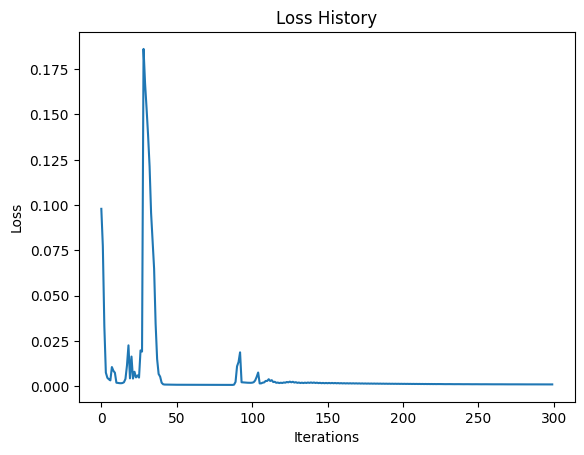

In [10]:
plt.plot(trainer.epoch_losses)
plt.title("Loss History")
plt.xlabel("Iterations")
plt.ylabel("Loss")

The plot shows, that DiffTRe is able to learn the correct ensemble average.

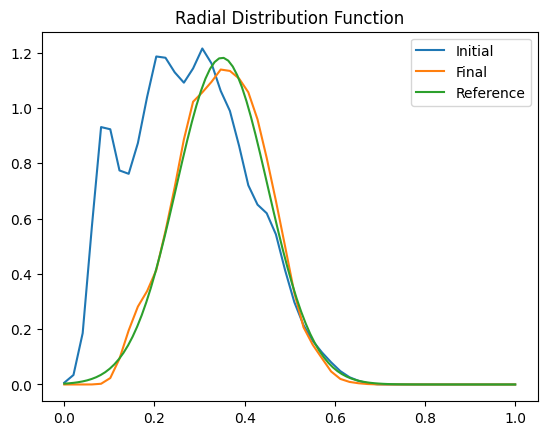

In [11]:
last_epoch = len(trainer.predictions[0]) - 1

plt.plot(onp.linspace(0.00, 1.0, 50), trainer.predictions[0][0]['rdf'], label="Initial")
plt.plot(onp.linspace(0.00, 1.0, 50), trainer.predictions[0][last_epoch]['rdf'], label="Final")
plt.plot(r, radial_distribution(r), label="Reference")
plt.legend()
plt.title("Radial Distribution Function")
plt.show()

Let's also take a look at the inferred parameters.

In [12]:
print(trainer.params)

{'r_0': Array(0.34312922, dtype=float32), 'scaled_b': Array(2.3707056, dtype=float32)}


## Further Reading

### Examples

- [CG Water from Structural Data](../examples/CG_water_difftre.ipynb)

### Publications

1. Thaler, S., Zavadlav, J. *Learning neural network potentials from experimental data via Differentiable Trajectory Reweighting*. Nat Commun 12, 6884 (2021). <https://doi.org/10.1038/s41467-021-27241-4>
2. Carles Navarro and Maciej Majewski and Gianni de Fabritiis *Top-down machine learning of coarse-grained protein force-fields*. arXiv (2023). <https://arxiv.org/abs/2306.11375>

## References

[^Ingraham2019]: Ingraham, J.; Riesselman, A.; Sander, C.; Marks, D. LEARNING PROTEIN STRUCTURE WITH A DIFFERENTIABLE SIMULATOR. **2019**.

[^Thaler2021]: Thaler, S.; Zavadlav, J. Learning Neural Network Potentials from Experimental Data via Differentiable Trajectory Reweighting. _Nat Commun_ **2021**, _12_ (1), 6884. [https://doi.org/10.1038/s41467-021-27241-4](https://doi.org/10.1038/s41467-021-27241-4).

[^Torrie1977]: Torrie, G. M.; Valleau, J. P. Nonphysical Sampling Distributions in Monte Carlo Free-Energy Estimation: Umbrella Sampling. _Journal of Computational Physics_ **1977**, _23_ (2), 187–199. [https://doi.org/10.1016/0021-9991(77)90121-8](https://doi.org/10.1016/0021-9991(77)90121-8).

[^Ceriotti2021]: Ceriotti, M.; Brain, G. A. R.; Riordan, O.; Manolopoulos, D. E. The Inefficiency of Re-Weighted Sampling and the Curse of System Size in High-Order Path Integration. _Proceedings: Mathematical, Physical and Engineering Sciences_ **2012**, _468_ (2137), 2–17.

[^Carmichael2012]: Carmichael, S. P.; Shell, M. S. A New Multiscale Algorithm and Its Application to Coarse-Grained Peptide Models for Self-Assembly. _J. Phys. Chem. B_ **2012**, _116_ (29), 8383–8393. [https://doi.org/10.1021/jp2114994](https://doi.org/10.1021/jp2114994).